In [1]:
from __future__ import print_function

%matplotlib inline
#%matplotlib widget
import numpy
import matplotlib.pyplot as plt
from scipy import integrate

import csv
import time
import struct

In [42]:
def readApprox(filename):
    fp = open(filename,"r")
    csvFile = csv.reader(fp,delimiter=",")
    
    firstRow = next(csvFile)
    x = numpy.array(firstRow,dtype=numpy.float64)
    
    secondRow = next(csvFile)
    w = numpy.array(secondRow,dtype=numpy.float64)

    
    numRows = 0
    allData = []
    approx = numpy.arange(0)
    for line in csvFile:
        line = numpy.array(line,dtype=numpy.float64)
        allData.append(line)
        numRows += 1

    approx = numpy.zeros((numRows,len(allData[0])-1))
    timeSteps = numpy.zeros(numRows)
    numRows = 0
    for line in allData:
        approx[numRows,:] = line[1:]
        timeSteps[numRows] = line[0]
        numRows += 1
            
    fp.close()
    
    return(x,timeSteps,approx)

def readBinary(filename):
    fp = open(filename,"rb")
    print("reading from {0}".format(filename))
    
    # First read in the parameters
    mu = struct.unpack('d',fp.read(8))[0]
    c = struct.unpack('d',fp.read(8))[0]
    g = struct.unpack('d',fp.read(8))[0]
    d = struct.unpack('d',fp.read(8))[0]
    m = struct.unpack('d',fp.read(8))[0]
    print("Reading file. mu: {0}, c: {1}, g: {2}, d: {3} m: {4}".format(mu,c,g,d,m))

    # Read in the polynomial degree
    N = fp.read(4)
    N = int.from_bytes(N,byteorder='little')

    # Read in the size of the state space
    S = fp.read(4)
    S = int.from_bytes(S,byteorder='little')

    # Read the abscissa
    x = fp.read(8*(N+1))
    x = numpy.array(struct.unpack('{0}d'.format(N+1),x))

    # Read the weights
    w = fp.read(8*(N+1))
    w = numpy.array(struct.unpack('{0}d'.format(N+1),w))


    allData = []
    allTime = []
    allTotalPopulation = []
    while(True):
        t = fp.read(8)
        if(len(t)>0):
            try:
                t = struct.unpack('d',t)[0]
                population = struct.unpack('d',fp.read(8))[0]
                state = numpy.array(struct.unpack('{0}d'.format(N+2),fp.read(8*(N+2))))
            except:
                break
            else:
                #for lupe in range(len(state)):
                #    if(state[lupe] < 0.0):
                #        state[lupe] = 0.0
                allTime.append(t)
                allTotalPopulation.append(population)
                allData.append(state)

        else:
            break


    fp.close()
    
    timeSteps = numpy.array(allTime)
    totalPop  = numpy.array(allTotalPopulation)
    approx    = numpy.zeros((len(allData),N+1))
    wasps     = numpy.zeros(len(allData))
    row = 0
    for line in allData:
        approx[row,0:(N+1)] = line[0:(N+1)]
        wasps[row] = line[N+1]
        row += 1

    return([x,timeSteps,totalPop,approx,wasps,mu,c,g,d,m])


reading from /tmp/steadyState_c-2.0000.bin
Reading file. mu: 0.015, c: 2.0, g: 0.6, d: 0.1 m: 20.0
Final Time: 0.000
[1.96231405 5.11289169]
[ 6.24233518e-01  6.23310818e-01  6.18774021e-01  6.05842457e-01
  5.77873188e-01  5.24786078e-01  4.33741093e-01  2.98057432e-01
  1.46537075e-01  4.47295572e-02  9.19262921e-03  1.61665714e-03
  2.67291359e-04  4.35179778e-05  1.01178273e-05 -6.87070488e-07
  1.65755540e-06 -2.64264321e-07 -8.90913409e-07  2.23440316e-06
 -3.57710520e-06  4.87220517e-06 -6.04162192e-06  7.01075757e-06
 -7.71877721e-06  8.10976376e-06 -8.15166539e-06  7.81403517e-06
 -7.07332275e-06  5.86260060e-06 -3.97434546e-06]


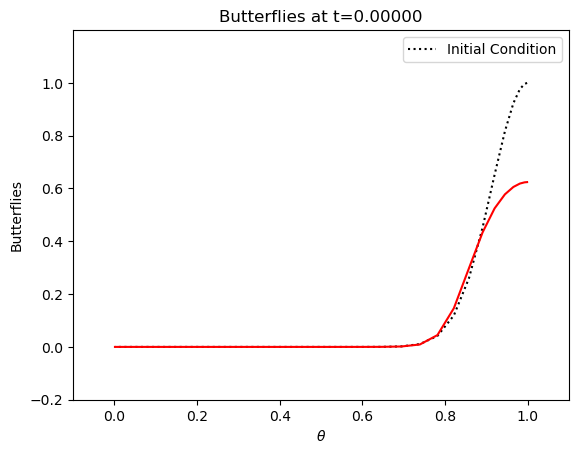

In [182]:
#[x,timeSteps,approx] = readApprox("../build-butterflyVWaspPDE-Desktop-Debug/approximation.csv")
#print("Final Time: {0:.3f}".format(timeSteps[-1]))

filename = "/tmp/steadyState_c-2.0000.bin" # "../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.0100-mu-0.0100.bin"
[x,timeSteps,totalPop,approx,wasps,mu,c,g,d,m] = readBinary(filename)
x = (x+1.0)*0.5
print("Final Time: {0:.3f}".format(timeSteps[-1]))
#print(approx[0])
print(wasps)
print(approx[1])

maxVal = numpy.max(numpy.array([numpy.max(approx[0]),numpy.max(approx[1])]))
minVal = numpy.min(numpy.array([numpy.min(approx[0]),numpy.min(approx[1])]))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
plt.ion()
axes.clear()
axes.set_xlabel("$\\theta$")
axes.set_ylabel("Butterflies")
axes.set_title("Butterflies at t={0:.5f}".format(0.0))
#axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.set_xlim(-0.1, 1.1)
axes.set_ylim(minVal-0.2, maxVal+0.2)
butterflyPlot = axes.plot(x,approx[0],'k:',label="Initial Condition")
butterflyPlot = axes.plot(x,approx[1],'r')
axes.legend(loc="upper right")
fig.canvas.draw()


In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
#%matplotlib notebook

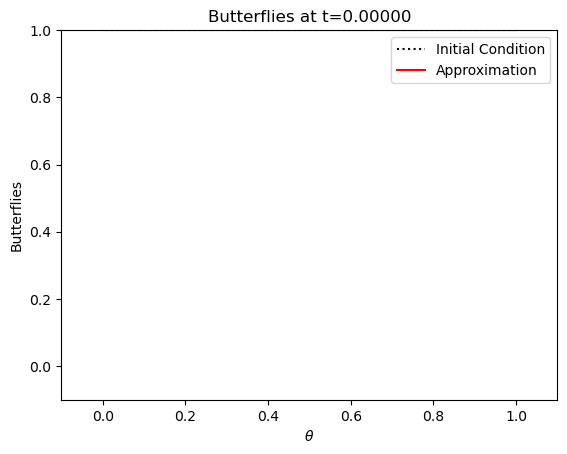

In [25]:
#%autoreload 1
#%matplotlib notebook
#%matplotlib widget


t    = 0
row  = 0
skip = 10;

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
plt.ion()
#fig.show()
maxVal = 0.7;

#for timeIndex in range(0,approx.shape[0],skip):
for timeIndex in range((approx.shape[0]-1),approx.shape[0],skip):
    #print(butterFly)
    
    if(maxVal<numpy.max(approx[timeIndex])):
        maxVal = numpy.max(approx[timeIndex])
    
    axes.clear()
    axes.set_xlabel("$\\theta$")
    axes.set_ylabel("Butterflies")
    axes.set_title("Butterflies at t={0:.5f}".format(timeSteps[timeIndex]))
    #axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
    axes.set_xlim(-0.1, 1.1)
    axes.set_ylim(-0.1, maxVal)

    butterflyPlot = axes.plot(x,approx[0],'k:',label="Initial Condition")
    butterflyPlot = axes.plot(x,approx[timeIndex],'r',label="Approximation")
    axes.legend(loc="upper right")
    fig.canvas.draw()
    time.sleep(0.02)



reading from /tmp/trialApprox.bin
Reading file. mu: 0.01, c: 2.0, g: 0.6, d: 0.1 m: 10.0
Final Time: 103.020
0.03636363636363637 0.4


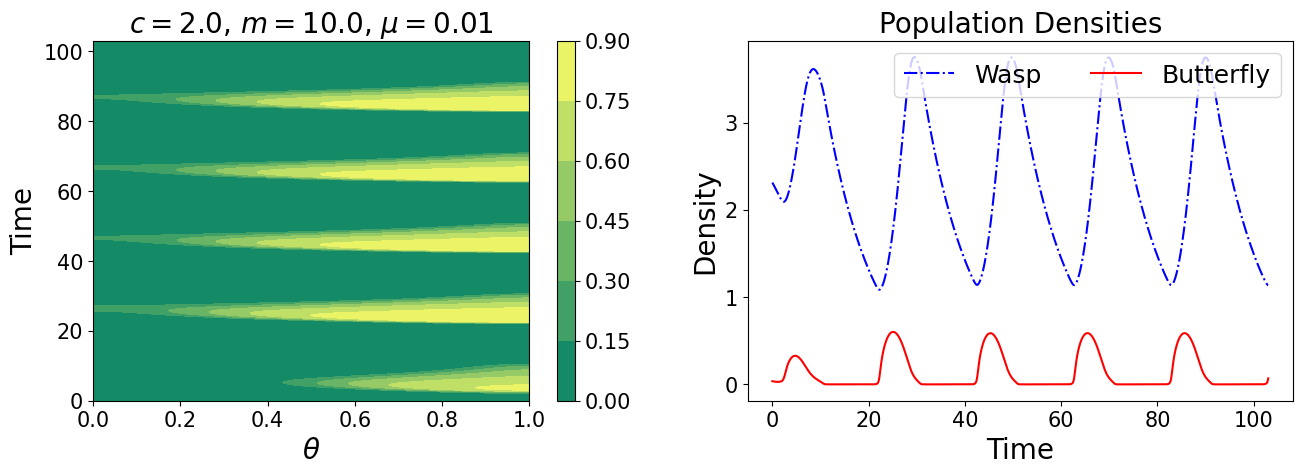

In [21]:
filename = '/tmp/trialApprox.bin' #'/tmp/approximation-m-5.0.bin'

[x,timeSteps,totalPop,approx,wasps,mu,c,g,d,m] = readBinary(filename)
x = (x+1.0)*0.5
print("Final Time: {0:.3f}".format(timeSteps[-1]))
highButterfly = d*c/((1)*(g-d))
lowButterfly = d*c/((m+1.0)*(g-d))
print(lowButterfly,highButterfly)

parameters = {'xtick.labelsize': 15,'ytick.labelsize': 15}
plt.rcParams.update(parameters)

fig = plt.figure()
#fig.subplots_adjust(bottom=-0.0,top=2.0,right=2) #bottom=-3.0,top=1.0)
fig.subplots_adjust(bottom=-0.0,top=0.75,right=2) #bottom=-3.0,top=1.0)

axes = fig.add_subplot(1,2,1)

[XGrid,TGrid] = numpy.meshgrid(x,timeSteps)
cp = axes.contourf(XGrid,TGrid,approx,cmap='summer') #gist_yarg Greens BuGn
fig.colorbar(cp) # Add a colorbar to a plot
axes.set_title('$c={0}$, $m={2}$, $\\mu={1}$'.format(c,mu,m),fontsize=20)
axes.set_xlabel(r'$\theta$',fontsize=20)
axes.set_ylabel('Time',fontsize=20)

axes1 = fig.add_subplot(1, 2, 2)
axes1.plot(timeSteps,wasps,'b-.',label="Wasp")
axes1.plot(timeSteps,totalPop,'r-',label="Butterfly")

axes1.set_title('Population Densities',fontsize=20)
axes1.set_xlabel('Time',fontsize=20)
axes1.set_ylabel('Density',fontsize=20)
axes1.legend(loc="upper right",fontsize=18,ncol=2)



plt.show()

reading from /tmp/trialApprox.bin
Reading file. mu: 0.01, c: 2.0, g: 0.6, d: 0.1 m: 10.0
Final Time: 99.345
0.03636363636363637 0.4


<IPython.core.display.Javascript object>


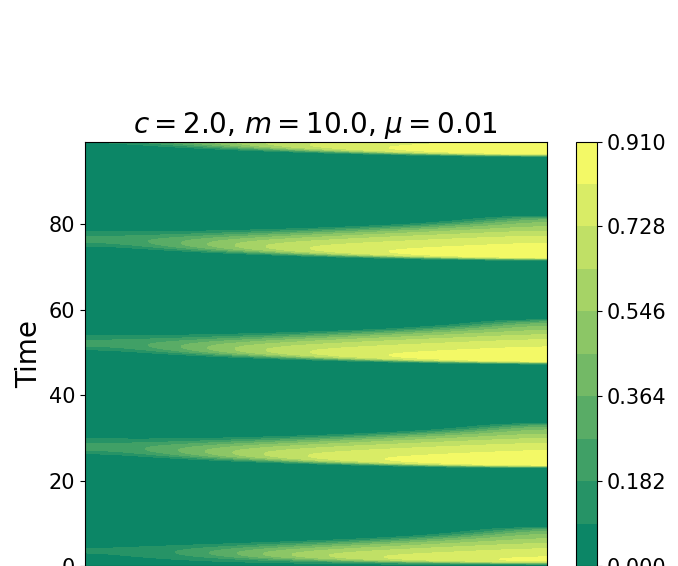

In [11]:
#%matplotlib inline
%reload_ext autoreload
%autoreload 0

#[x,timeSteps,approx] = readApprox("../build-butterflyVWaspPDE-Desktop-Debug/approximation.csv")
#print("Final Time: {0:.3f}".format(timeSteps[-1]))

#filename = "../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-1.0000-mu-0.5000.bin"
#filename = "../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-15.0000-mu-0.5000.bin"
#filename = "../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-5.0000-mu-0.5000.bin"

#filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.0100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.1100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.2100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.3100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.4100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.5100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.6100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.7100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.8100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.9100-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-1.5000-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-9.5000-mu-0.0100.bin'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-12.0000-mu-0.0100.bin'

#filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-TRIAL--c-2.7500-m-13.0000-mu-0.0095.bin'
#filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-TRIAL--c-2.7500-m-9.7500-mu-0.0095.bin'
#filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-TRIAL--c-2.7500-m-6.5000-mu-0.0095.bin'

filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-12.0000-mu-0.0100.bin'
pdfName  = '/tmp/approximation-mu-01-m-12.pdf'

filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.0100-mu-0.0100.bin'
pdfName  = '/tmp/approximation-c-11-mu-01-m-01.pdf'

filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-0.5100-mu-0.0100.bin'
pdfName  = '/tmp/approximation-c-11-mu-01-m-51.pdf'

filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-1.5000-mu-0.0100.bin'
pdfName  = '/tmp/approximation-c-11-mu-01-m-150.pdf'

#filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-1.0000-mu-0.0100.bin'
#filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-c-1.1000-m-1.0000-mu-0.0100.bin'

filename = "../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-1.0.bin"
pdfName = '/tmp/approximation-m-1.0.pdf'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-4.5.bin'
pdfName = '/tmp/approximation-m-4.5.pdf'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-10.0.bin'
pdfName = '/tmp/approximation-m-10.0.pdf'
filename = '../build-butterflyVWaspPDE-Desktop-Debug/approximation-m-18.0.bin'
pdfName = '/tmp/approximation-m-18.0.pdf'

filename = "/tmp/trialApprox.bin"
pdfName  = "/tmp/trialApproximation.pdf"

[x,timeSteps,totalPop,approx,wasps,mu,c,g,d,m] = readBinary(filename)
x = (x+1.0)*0.5
print("Final Time: {0:.3f}".format(timeSteps[-1]))
highButterfly = d*c/((1)*(g-d))
lowButterfly = d*c/((m+1.0)*(g-d))
print(lowButterfly,highButterfly)

parameters = {'xtick.labelsize': 15,'ytick.labelsize': 15}
plt.rcParams.update(parameters)

fig = plt.figure()
#fig.subplots_adjust(bottom=-0.0,top=2.0,right=2) #bottom=-3.0,top=1.0)
fig.subplots_adjust(bottom=-0.0,top=0.75,right=2) #bottom=-3.0,top=1.0)

axes = fig.add_subplot(1,2,1)

[XGrid,TGrid] = numpy.meshgrid(x,timeSteps)
cp = axes.contourf(XGrid,TGrid,approx,numpy.linspace(0.0,0.91,11),cmap='summer') #gist_yarg Greens BuGn
fig.colorbar(cp) # Add a colorbar to a plot
axes.set_title('$c={0}$, $m={2}$, $\mu={1}$'.format(c,mu,m),fontsize=20)
axes.set_xlabel(r'$\theta$',fontsize=20)
axes.set_ylabel('Time',fontsize=20)

axes1 = fig.add_subplot(1, 2, 2)
#axes1.plot(timeSteps,wasps,'b-.',label="Wasp")
axes1.plot(timeSteps,totalPop,'r-',label="Butterfly")
#axes1.plot(numpy.array([0.0,timeSteps[-1]]),
#           numpy.array([lowButterfly,lowButterfly]),'k:')
#axes1.plot(numpy.array([0.0,timeSteps[-1]]),
#           numpy.array([highButterfly,highButterfly]),'k:')
#axes1.set_ylim([0, numpy.max(wasps)*1.2])
axes1.set_ylim(0,1.0)

#axes1.set_title('Population Densities',fontsize=20)
axes1.set_xlabel('Time',fontsize=20)
axes1.set_ylabel('Butterfly Density',fontsize=20)

#handles, labels = ax.get_legend_handles_labels()
#plt.legend(flip(handles, 2), flip(labels, 2), loc=9, ncol=2)
#axes1.legend(loc="center right",fontsize=18,ncol=2)

#axes2 = fig.add_subplot(2, 2, 3)
#axes2.plot(totalPop,wasps)
#axes2.plot(totalPop[0],wasps[0],'rD')
#axes2.set_title('Butterfly/Wasp Phase Plane')
#axes2.set_xlabel('Butterfly')
#axes2.set_ylabel('Wasp')


plt.show()

fig.savefig(pdfName, dpi=60, bbox_inches='tight')


In [ ]:
approx[2]

In [ ]:
import csv

f = open("/tmp/crossSections.csv","w")
c = csv.writer(f)
c.writerow(x)
c.writerow(approx[200000])
c.writerow(approx[100000])
f.close()


In [10]:
from matplotlib.animation import FuncAnimation